<a href="https://colab.research.google.com/github/chettkulkarni/MachineLearning/blob/master/Wildfire_cause_prediction_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Wildfire Cause Prediction**

##Team: FourReal

1. Nupur Yadav
2. Chetan Kulkarni
3. Lokesh Vadlamudi
4. Ronak Mehta

##**Problem Definition:**

The number of wildfire cases have drastically increased in the past few years, with more than 52,000 fires in 2018 alone. The goal of this project is to predict the cause of wildfire using meteorological and other weather related data such as location, day of the week, month, temperature and so on. This type of prediction can help government to monitor and mitigate impact of these fires by allocating proper resources based on the cause of fire.

##**Datasets:**

We have taken our base dataset from kaggle (https://www.kaggle.com/rtatman/188-million-us-wildfires) which had 1.88 million historic fires from throughout the United States and during the period of
1992-2015. It had features such as fire cause code (1-13) specifying what started the fire, fire cause description, latitude, and longitude, discovery date etc. 

In our dataset the fire cause code has values from 1-13 mapped to below fire cause description.

1 - Lightning

2 - Equipment Use

3 - Smoking

4 - Campfire

5 - Debris Burning

6 - Railroad

7 - Arson

8 - Children

9 - Miscellaneous

10 - Fireworks

11 - Powerline

12 - Structure

13 - Missing/Undefined

But it didn't have weather related data which was crucial for our prediction so we **amalgamated our base dataset with weather dataset from National Oceanic and Atmospheric Administration (ncdc.novaa.gov website)** and added fields such as Temperature, snow, precipitation, TOBS to our dataset.

##**Importing necessary libraries and loading our base dataset**



In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import random
random.seed(1)

In [0]:
#Importing Libraries
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import tree, preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA


%matplotlib inline


#Importing Libraries
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import tree, preprocessing

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/open?id=1ApRYxyMqnFKH8XW1GbQ-KZNJdbdeEdV9'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1ApRYxyMqnFKH8XW1GbQ-KZNJdbdeEdV9


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Fire.csv')

In [0]:
#Loading dataset into pandas dataframe
df = pd.read_csv('Fire.csv')

In [8]:
#Displaying first few records
df.head()

,Unnamed: 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,NaN,NaN,NaN,NaN,NaN,2005,2453403.5,33,1300.0,9.0,Miscellaneous,2453403.5,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,13,AAC0,PIGEON,NaN,NaN,NaN,NaN,NaN,2004,2453137.5,133,845.0,1.0,Lightning,2453137.5,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27,021,A32W,SLACK,NaN,NaN,NaN,NaN,NaN,2004,2453156.5,152,1921.0,5.0,Debris Burning,2453156.5,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43,6,NaN,DEER,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44,7,NaN,STEVENOT,NaN,NaN,NaN,NaN,NaN,2004,2453184.5,180,1600.0,1.0,Lightning,2453189.5,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


##**Preprocessing data**

In [9]:
#Checking the columns in dataset
df.columns

Index(['Unnamed: 0', 'OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE',
       'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [10]:
#Displaying the shape of data
df.shape

(1880465, 40)

In [0]:
#Creating a new data frame with required columns
df = df[['FIRE_YEAR','STAT_CAUSE_CODE','STAT_CAUSE_DESCR','LATITUDE','LONGITUDE','STATE','DISCOVERY_DATE','FIRE_SIZE']].copy()

In [12]:
#Checking for the missing values in the dataset
df.isnull().sum()

FIRE_YEAR           0
STAT_CAUSE_CODE     0
STAT_CAUSE_DESCR    0
LATITUDE            0
LONGITUDE           0
STATE               0
DISCOVERY_DATE      0
FIRE_SIZE           0
dtype: int64

As we can see our dataset don't have any missing values.

In [13]:
#Displaying top 5 records
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [14]:
#Converting the DISCOVERY_DATE field's Julian Date format in Gregorian dates
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.head() #check the data

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28


In [15]:
#Getting some additional data fields such as month and day of the week.
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0


Day_OF_Week with Monday=0, Sunday=6.

In [0]:
df_orig=df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE',	'LONGITUDE',	'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE',	'MONTH', 'DAY_OF_WEEK']]

##**Exploratory data analysis**

Doing some exploratory data analysis to see how the features are correlated, what are relevant features for our prediction and if any hidden information we can get to facilitate our prediction.

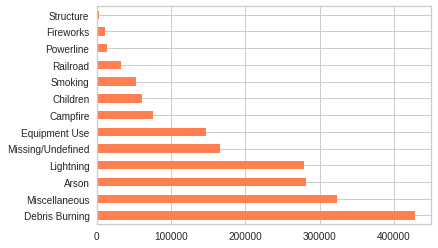

In [17]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

Our dataset has around 13 causes which are too many classes. May be we will try to club these causes to reduce the number of classes and see if this improves our model accuracy.

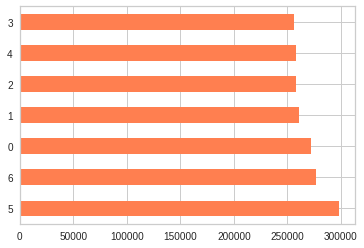

In [18]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The above graph shows that on weekends (5&6) the fires discovered are slightly more. We are assuming that is because of the people being careless on weekends with campfires or smoking or probably because of some malicious intent. Now, we would like to see how fires are distributed across the weekdays because of the natural causes such as lightning.

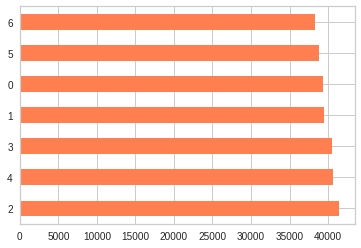

In [19]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

As we can see the fires are more on weekdays now and lowered on weekends. I am imagining if the increase on weekends is due to malicious fires such as - Arson. So now we will check the fire distribution on weekdays because of Arson.

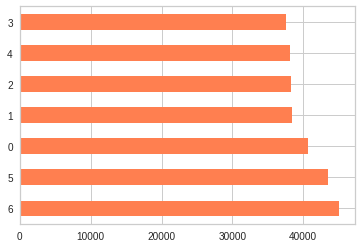

In [20]:
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The above graph makes it significant that the increase in fire on weekends is because of Arson. We can see probably a 30% increase on weekends than the average of weekdays.

This also proves that Day_Of_Week is an important feature to be kept in our feature set.

In [0]:
sns.pairplot(df)

###**Performing K-Means Clustering as part of EDA**

We tried clustering based on some selected features to see if we can gain any other insights from our dataset.

In [0]:
#K-means clustering on fire cause and fire size
data = df[['FIRE_SIZE','STAT_CAUSE_CODE']]

####**Using Elbow method to find optimal k**

In [0]:
# Sum_of_squared_distances = []
# K = range(1,10)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(data)
#     Sum_of_squared_distances.append(km.inertia_)

In [0]:
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

We got optimal k as 3.

####**Silhouette score analysis**

In [0]:
# from yellowbrick.cluster import KElbowVisualizer
# model = KMeans(random_state=0)
# visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette', timings=False)

# visualizer.fit(data)    
# visualizer.poof() 

From Silhouette score analysis we got that 3 clusters are optimal. Silhoutte score = 0.86

In [0]:
#Applying K-means for optimal k=3
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(data)

In [26]:
#Adding cluster column to dataset for further analysis
df['cluster'] = y
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK,cluster
0,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2,0
1,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2,0
2,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0,0
3,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0,0
4,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0,0


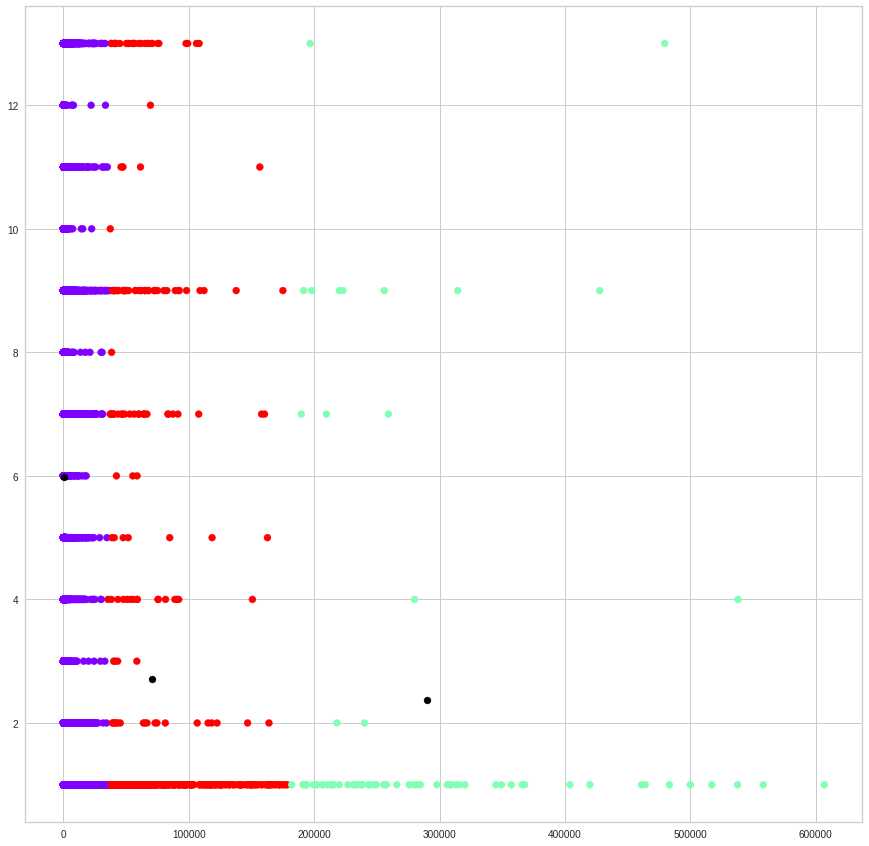

In [27]:
#Plotting the clusters obtained
plt.figure(1,figsize=(15,15))
plt.scatter(df.FIRE_SIZE, df.STAT_CAUSE_CODE, c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

As we can see, the above clusters didn't obtain any meaningful information.

**Performing k-means clustering on latitude and longitude to see the geagraphical coverage of the data**

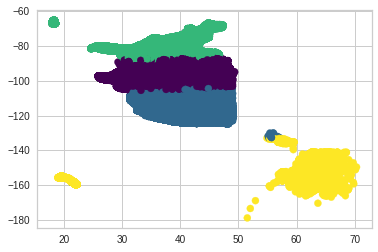

In [28]:
kmeans1 = KMeans(n_clusters=4,random_state=0).fit(df[['LATITUDE','LONGITUDE']])
y_means1 = kmeans1.predict(df[['LATITUDE','LONGITUDE']])
plt.scatter(df['LATITUDE'],df['LONGITUDE'], c=y_means1, s=50, cmap='viridis')

The above plot clearly shows the map of United States and most of the fires have occurred in longitutes between -100 and -120 which is majorly California region.

###**Correlation matrix**

Plotting correlation matrix to get a better understanding of how the features are correlated.

In [29]:
#First converting all features to numeric
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df = df.drop(['cluster'], axis=1)
df.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,9.0,7,40.036944,-121.005833,4,2453403.5,0.10,2005-02-02,2,2
1,2004,1.0,6,38.933056,-120.404444,4,2453137.5,0.25,2004-05-12,5,2
2,2004,5.0,3,38.984167,-120.735556,4,2453156.5,0.10,2004-05-31,5,0
3,2004,1.0,6,38.559167,-119.913333,4,2453184.5,0.10,2004-06-28,6,0
4,2004,1.0,6,38.559167,-119.933056,4,2453184.5,0.10,2004-06-28,6,0


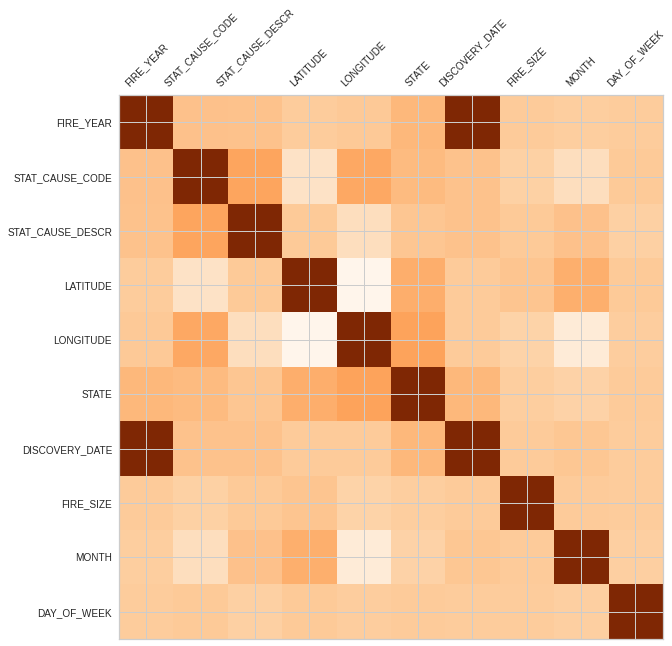

In [30]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(df)

In the above plot darker shades means strong correlation wheras white shade means no correlation. We can see that month is strongly correlated to latitude wheras weakly correlated to longitide.

##**Preparing data for Machine learning**

In [0]:
models_dict={}
models_dict['LogisticRegression']        = LogisticRegression()
models_dict['Dtree']     = DecisionTreeClassifier()
models_dict['NB']        = GaussianNB()
models_dict['KNN']       = KNeighborsClassifier()
models_dict['RForest']   = RandomForestClassifier(n_estimators=50)
models_dict['XGB']       = XGBClassifier()

In [0]:
#function to compare the different algorihths based on recall of model 
def compareAlgos(model_results):
  fig = plt.figure(figsize=(11,6))
  fig.suptitle('Algorithm Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot([modelresult for name,modelresult in model_results.items()])
  ax.set_xticklabels([name for name,modelresult in model_results.items()])
  plt.show()

#writing a functional api layer which takes models , trains and tests and plots comparision of those models on a graph 
def fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test):
  accuracy={}
  specificity={}
  sensitivity={}
  #models_dict holds name and its function , like {'LR':LogsticRegression()}
  for name,model in models_dict.items():
    try:
      #fitting model on the train data
      model.fit(X_train,y_train)
      #predicting model on X_test 
      y_pred=model.predict(X_test)
      print('*'*100)
      print('Model:',name)
      #printing Confusion matrix an dAccuracy of each model
      print("Confusion Matrix: ",confusion_matrix(y_test, y_pred)) 
      print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

      #mainitaing a dictionary of results of accuracy of each model to use it to plot in one systyem
      accuracy[name]=accuracy_score(y_test,y_pred)*100
      cm=confusion_matrix(y_test, y_pred)
      sensitivity[name] = (cm[0,0]/(cm[0,0]+cm[0,1]))*100
      specificity[name] = (cm[1,1]/(cm[1,0]+cm[1,1]))*100
      print("Classificarion Report : ")
      print(classification_report(y_test, y_pred))
    except ValueError:
      print(name,'failed')
  
  #converting dictionaries to dataframes to have them handy
  accuracy=pd.DataFrame.from_dict(accuracy,orient='index').reset_index()
  sensitivity=pd.DataFrame.from_dict(sensitivity,orient='index').reset_index()
  specificity=pd.DataFrame.from_dict(specificity,orient='index').reset_index()
  # print(accuracy)
  accuracy.columns=['model_name','accuracy']
  sensitivity.columns=['model_name','sensitivity']
  specificity.columns=['model_name','specificity']
  
  #plotting accuracy,sensitivity,specificity of each model
  plt.figure(figsize=(16, 6))
  ax = sns.lineplot(data=accuracy, x='model_name', y='accuracy',legend='full')
  ax = sns.lineplot(data=sensitivity, x='model_name', y='sensitivity',legend='full')
  ax = sns.lineplot(data=specificity, x='model_name', y='specificity',legend='full')
  ax = sns.barplot(data=accuracy, x='model_name', y='accuracy')
  plt.title('Blue :Accuracy,Orange: Senstivity,Green : Specicificity ')

In [33]:
df_orig

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2,2
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,5,2
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,5,0
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,6,0
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,6,0
...,...,...,...,...,...,...,...,...,...
1880460,2015,Missing/Undefined,40.481637,-122.389375,CA,2457291.5,0.01,9,5
1880461,2015,Miscellaneous,37.617619,-120.938570,CA,2457300.5,0.20,10,0
1880462,2015,Missing/Undefined,37.617619,-120.938570,CA,2457144.5,0.10,5,5
1880463,2015,Missing/Undefined,37.672235,-120.898356,CA,2457309.5,2.00,10,2


In [0]:
df = df.drop('DATE',axis=1)
df = df.drop('STAT_CAUSE_CODE', axis=1)
df = df.dropna()

In [0]:
X = df.drop(['STAT_CAUSE_DESCR'], axis=1).values
Y = df['STAT_CAUSE_DESCR'].values

In [0]:
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1)

####**Applying Random Forest Classifier on base dataset with 13 classes in target variable**

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix:  [[     0      0      0 112595      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  30343      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  24468      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 171639      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  59223      0      0      0      0      0      0
       0      0      0]
 [     0      0      0   4562      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 111672      0      0      0      0      0      0
       0      0      0]
 [     0      0      0 129458      0      0      0      0      0      0
       0      0      0]
 [     0      0      0  66484      0      0      0      0      0      0
       0      

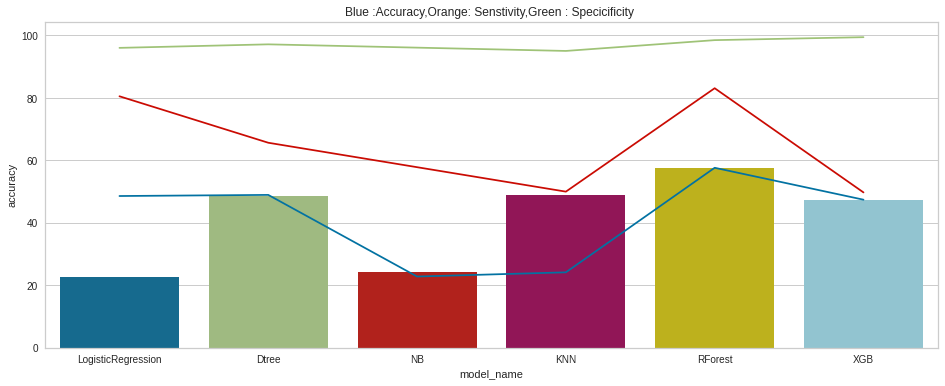

In [37]:

fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

###**Importing amalgamated fire dataset which contains weather related columns such as Temperature, Precipitation, Snow etc. The weatherDataLoad.ipynb file contains the script to fetch data from National Oceanic and Atmospheric Administration (ncdc.novaa.gov website).**

In [39]:
link = 'https://drive.google.com/open?id=1qnqDNrDyxVPBTxE-6BTYDVz-7Iennl_m'
fluff, id = link.split('=')
print (id) 

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AmalgamatedFireDataset.csv')

1qnqDNrDyxVPBTxE-6BTYDVz-7Iennl_m


In [0]:
amal_df = pd.read_csv('AmalgamatedFireDataset.csv')
amal_df=amal_df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE_x', 'discovery_month', 'discovery_weekday', 'TMAX', 'PRCP', 'TOBS', 'SNOW']]

amal_df['STAT_CAUSE_DESCR'] = le.fit_transform(amal_df['STAT_CAUSE_DESCR'])
amal_df['STATE'] = le.fit_transform(amal_df['STATE'])
amal_df['discovery_month'] = le.fit_transform(amal_df['discovery_month'])
amal_df['discovery_weekday'] = le.fit_transform(amal_df['discovery_weekday'])

In [0]:
X = amal_df.drop(['STAT_CAUSE_DESCR'], axis=1).values
Y = amal_df['STAT_CAUSE_DESCR']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [0]:
model_results={}
scoring = 'recall'
seed=1

#performing K Folds na dtestin the recall of each model, Printing recall mean and standard deviation 
kfold = KFold(n_splits=10, random_state=seed)
for name, model in models_dict.items():
  try:       
        model_results[name]=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        msg = "%s: %f (%f)" % (name, model_results[name].mean(), model_results[name].std())
        print(msg)
  except ValueError:
    print(name,'failed')
compareAlgos(model_results)

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix:  [[    0     0     0     0     0     0 16994     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  8586     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  4012     0     0     0     0     0
      0]
 [    0     0     0     0     0     0 21707     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  8545     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  1351     0     0     0     0     0
      0]
 [    0     0     0     0     0     0 26415     0     0     0     0     0
      0]
 [    0     0     0     0     0     0 22352     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  6259     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  1466     0     0     0     0     0
      0]
 [    0     0     0     

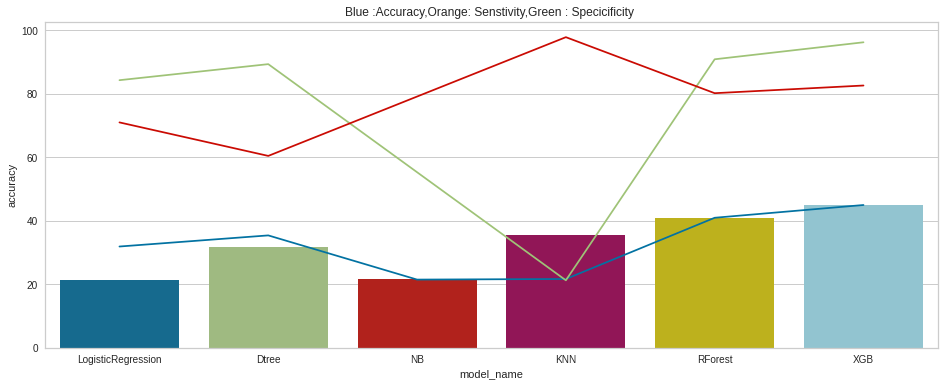

In [42]:

fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

In [0]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Arson','Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    else:
        cause = 3
    return cause

In [0]:
amal_df = pd.read_csv('AmalgamatedFireDataset.csv')
amal_df_orig=amal_df
amal_df=amal_df[['FIRE_YEAR', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE_x', 'discovery_month', 'discovery_weekday', 'TMAX', 'PRCP', 'TOBS', 'SNOW']]
amal_df['STAT_CAUSE_DESCR'] = le.fit_transform(amal_df['STAT_CAUSE_DESCR'])
amal_df['STATE'] = le.fit_transform(amal_df['STATE'])
amal_df['discovery_month'] = le.fit_transform(amal_df['discovery_month'])
amal_df['discovery_weekday'] = le.fit_transform(amal_df['discovery_weekday'])


X = amal_df.drop(['STAT_CAUSE_DESCR'], axis=1).values
Y = amal_df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))

In [55]:
pca = PCA(n_components=0.999)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (615282, 12)
transformed shape: (615282, 3)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [0]:
model_results={}
scoring = 'recall'
seed=1

#performing K Folds na dtestin the recall of each model, Printing recall mean and standard deviation 
kfold = KFold(n_splits=10, random_state=seed)
for name, model in models_dict.items():
  try:       
        model_results[name]=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        msg = "%s: %f (%f)" % (name, model_results[name].mean(), model_results[name].std())
        print(msg)
  except ValueError:
    print(name,'failed')
compareAlgos(model_results)

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix:  [[  133 26282     0]
 [   44 67987     0]
 [   35 28576     0]]
Accuracy :  55.356460827096384
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.63      0.01      0.01     26415
           2       0.55      1.00      0.71     68031
           3       0.00      0.00      0.00     28611

    accuracy                           0.55    123057
   macro avg       0.39      0.33      0.24    123057
weighted avg       0.44      0.55      0.40    123057

****************************************************************************************************
Model: Dtree
Confusion Matrix:  [[16932  6407  3076]
 [ 6746 49156 12129]
 [ 3538 15229  9844]]
Accuracy :  61.704738454537335
Classificarion Report : 
              precision    recall  f1-score   support

           1       0.62      0.64      0.63  